In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Questions
- How do I fine tune the ML models? 
- - The first iteration in the backtesting or 

- How do I fine tune the bootstrapping approach?
- - The paper uses expected blocksize of 0.5 and 2 years. We can use results in some combinations.

- Any other recommendations or things to consider?
Write down how they have been uniformized.
Explain how the uniformization is done with the whole dataset which is cheating.
Use feature_short as the features.


# Data pre-processing

- Features used is "Ebit_Ta", "Eps", "Mkt_Cap_3M_Usd", "Mom_5M_Usd", "Pb", "Pe", "Total_Debt_Capital", "Vol1Y_Usd".
- Time range beginning of 2005 - end of 2019
- Only kept stocks where we have full information of them (non missing value for each time period).


In [2]:
import pyreadr
data_ml = pyreadr.read_r("data/data_ml.Rdata")
data_ml = data_ml['data_ml']
data_ml.shape

(283380, 99)

In [3]:
# Data pre-processing
features = ["Ebit_Ta", "Eps", "Mkt_Cap_3M_Usd", "Mom_5M_Usd", 
            "Pb", "Pe", "Total_Debt_Capital", "Vol1Y_Usd"]
max_n_stocks = data_ml["stock_id"].value_counts().max()
data_ml = data_ml.loc[data_ml.groupby("stock_id").date.transform("count") == max_n_stocks]
data_ml = data_ml.loc[data_ml['date'] >= pd.Timestamp("2005-01-01")]
data_ml['date'] = pd.to_datetime(data_ml['date'])

# Starting point for backtest
sep_oos = pd.to_datetime("2010-01-01")
t_oos = data_ml.loc[data_ml['date'] > sep_oos, 'date'].unique()
t_oos = pd.to_datetime(t_oos).sort_values()

# Model selection

- We only tune the model using our first iteration of backtesting, hence there is no re-tuning of model after.
- To avoid forward looking bias, we will be tuning using our training data from the first iteration in our backtesting. Instead of doing cross-validation, we will be segmenting a portion of this training data based on time. i.e. The training data here is from beg 2005 - end of 2007, validation data here is beg 2008 - first oot (first month of 2009).


In this section, we will be performing hyperparameter tuning for our ML models to be used in our backtesting. To avoid forward looking bias, we will be tuning using our training data from the first iteration in our backtesting. Instead of doing cross-validation, we will be segmenting a portion of this training data based on time.

In [4]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import xgboost as xgb
from sklearn.linear_model import ElasticNet

m_offset = 12                                          # Offset in months for buffer period
train_size = 5                                         # Size of training set in years
max_train_date = sep_oos

# Data prep
tune_dataset = data_ml[(data_ml['date'] < max_train_date - pd.Timedelta(days=m_offset * 30)) &  \
            (data_ml['date'] > max_train_date - pd.Timedelta(days=m_offset * 30 + 365 * train_size))]
tune_dataset = tune_dataset.sort_values('date').reset_index(drop=True)
x = tune_dataset[features]
y = tune_dataset["R12M_Usd"] / np.exp(tune_dataset["Vol1Y_Usd"])
print(f"shape of training set: {x.shape}")

# Pre-determine split by latest year in tune dataset, 2008
split_index = tune_dataset[tune_dataset['date'].dt.year == 2008].index.min()
test_fold = [-1] * split_index + [0] * (len(x) - split_index)
ps = PredefinedSplit(test_fold)

shape of training set: (17856, 8)


## Regression

In [5]:
en_params = {"alpha": [0.001, 0.005, 0.01],
             "l1_ratio": [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
en_cv = GridSearchCV(ElasticNet(random_state=2025), 
                     en_params, 
                     scoring='neg_root_mean_squared_error', 
                     cv=ps)
en_cv.fit(x, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=ElasticNet(random_state=2025),
             param_grid={'alpha': [0.001, 0.005, 0.01],
                         'l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
             scoring='neg_root_mean_squared_error')

In [6]:
cv_df = pd.DataFrame(en_cv.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
cv_df = pd.concat([cv_df['params'].apply(pd.Series), 
                   cv_df.drop(['params'], axis=1)], axis=1)
cv_df.sort_values('rank_test_score')

,alpha,l1_ratio,mean_test_score,rank_test_score
0,0.001,0.0,-0.405557,1
1,0.001,0.1,-0.405655,2
7,0.005,0.0,-0.405686,3
14,0.010,0.0,-0.405837,4
2,0.001,0.3,-0.405852,5
3,0.001,0.5,-0.406042,6
8,0.005,0.1,-0.406181,7
4,0.001,0.7,-0.406239,8
5,0.001,0.9,-0.406445,9
6,0.001,1.0,-0.406552,10


The above table shows that the best validation score was achieved when alpha=0.001 and l2_ratio=0. However, I will be using the parameters alpha=0.01 and l2_ratio=0 at rank 4, as this applies a heavier regularization while barely reducing the validation rmse. This provide a more stable and generalizable solution for unseen data.

## XGboost

In [7]:
test_params = {
 'max_depth':np.arange(5, 25, 5),
 'eta': np.array([0.001, 0.01, 0.05, 0.1])
}
xgb_cv = GridSearchCV(
    estimator = xgb.XGBRegressor(objective="reg:squarederror", 
                                  eval_metric='rmse',
                                  subsample=0.5, 
                                  min_child_weight=200,
                                  random_state=2025), 
    param_grid = test_params,
    cv=ps,
    scoring="neg_root_mean_squared_error")
xgb_cv.fit(x,y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', feature_types=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=200, missing=nan,
                                    monotone

In [8]:
cv_df = pd.DataFrame(xgb_cv.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
cv_df = pd.concat([cv_df['params'].apply(pd.Series), 
                   cv_df.drop(['params'], axis=1)], axis=1)
cv_df.sort_values('rank_test_score')

,eta,max_depth,mean_test_score,rank_test_score
11,0.050,20.0,-0.406089,1
9,0.050,10.0,-0.406150,2
8,0.050,5.0,-0.406315,3
10,0.050,15.0,-0.406428,4
4,0.010,5.0,-0.406608,5
6,0.010,15.0,-0.406662,6
7,0.010,20.0,-0.406662,6
5,0.010,10.0,-0.406691,8
14,0.100,15.0,-0.407167,9
12,0.100,5.0,-0.407224,10


Based on our results, we select the parameters eta=0.05 and max_depth=10 as the parameters looks reasonable, and the test scores do not differ a lot compared to the first choice.

# Portfolio backtesting

- Our benchmark will be an equally weighted portfolio including all stocks.
- We will be running our model against the risk-adjusted returns
- For each ML model, we will be train our model using our selected parameters from the previous section based on our risk-adjusted returns to speed up training. After using our models to predict the risk-adjusted returns, we will assign equal weights to the top 50 percentile of stocks with the highest predicted returns.

In this section, we perform the backtesting. To avoid forward looking bias from our features, we included a buffer period of one year between our train and test set. We also used a maximum training period of 5 years and iteratively shift the training dataset for each iteration.

Some important notes:
- Our benchmark will be an equally weighted portfolio including all stocks.
- We will be running our model against the risk-adjusted returns
- For each ML model, we will be train our model using our selected parameters from the previous section based on our risk-adjusted returns to speed up training. After using our models to predict the risk-adjusted returns, we will assign equal weights to the top 50 percentile of stocks with the highest predicted returns.

In [4]:
from utils import backtest

lr_params = {
    "l1_ratio":0, 
    "alpha":0.01, 
    "random_state":2025
}
xgb_params = {
    "eta": 0.05,        
    "max_depth": 10,               
    "objective": "reg:squarederror", 
    "subsample":0.5, 
    "eval_metric":"rmse",
    "random_state":2025
}
portf_weights, portf_returns = backtest(data_ml, features, t_oos, lr_params=lr_params, xgb_params=xgb_params)

2010-01-31 00:00:00
2011-01-31 00:00:00
2012-01-31 00:00:00
2013-01-31 00:00:00
2014-01-31 00:00:00
2015-01-31 00:00:00
2016-01-31 00:00:00
2017-01-31 00:00:00
2018-01-31 00:00:00
2019-01-31 00:00:00


# Metrics calcuations

In this section, we evaluate our models performance by considering returns of the portfolio, and turnover cost.

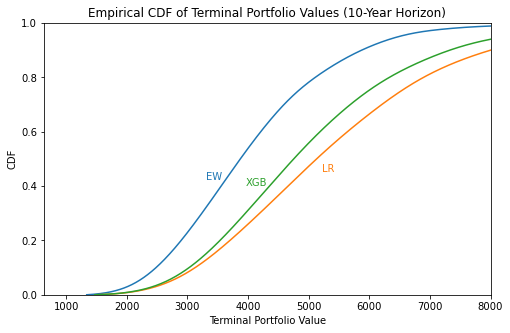

,strat,turnover,mean,std,sharpe,bt_mean,bt_std
0,EW,0.0555,0.0124,0.0482,0.2571,4054.9779,1331.0203
1,LR,0.5236,0.0149,0.0531,0.2814,5405.0825,1944.7093
2,XGB,0.6367,0.0143,0.0500,0.2850,5023.2362,1734.5110


In [5]:
from utils import perf_met_multi

blocksize_year = 1
p = 1/(blocksize_year * 12)
timeframe = 10
metrics_df = perf_met_multi(portf_returns=portf_returns, portf_weights=portf_weights, 
                            asset_returns=data_ml, t_oos=t_oos, strat_name=['EW', "LR", "XGB"], 
                            t=timeframe, p=p, xlim=8000, seed=2025)
metrics_df

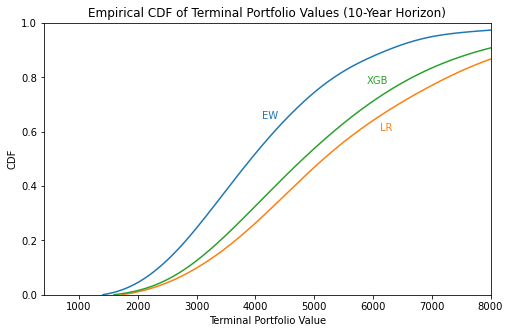

,strat,turnover,mean,std,sharpe,bt_mean,bt_std
0,EW,0.0555,0.0124,0.0482,0.2571,4154.4771,1596.2080
1,LR,0.5236,0.0149,0.0531,0.2814,5532.6549,2282.9045
2,XGB,0.6367,0.0143,0.0500,0.2850,5155.6057,2124.2577


In [6]:
blocksize_year = 0.5
p = 1/(blocksize_year * 12)
timeframe = 10
metrics_df = perf_met_multi(portf_returns=portf_returns, portf_weights=portf_weights, 
                            asset_returns=data_ml, t_oos=t_oos, strat_name=['EW', "LR", "XGB"], 
                            t=timeframe, p=p, xlim=8000, seed=2025)
metrics_df

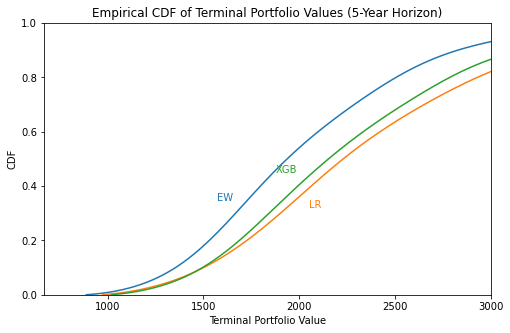

,strat,turnover,mean,std,sharpe,bt_mean,bt_std
0,EW,0.0555,0.0124,0.0482,0.2571,2027.7634,571.5235
1,LR,0.5236,0.0149,0.0531,0.2814,2342.8712,718.5359
2,XGB,0.6367,0.0143,0.0500,0.2850,2251.2307,648.4461


In [7]:
blocksize_year = 0.5
p = 1/(blocksize_year * 12)
timeframe = 5
metrics_df = perf_met_multi(portf_returns=portf_returns, portf_weights=portf_weights, 
                            asset_returns=data_ml, t_oos=t_oos, strat_name=['EW', "LR", "XGB"], 
                            t=timeframe, p=p, xlim=3000, seed=2025)
metrics_df